<h1><font color="orange" size=6.5>Implementación algoritmo FF-QRAM para QML</font></h1> 

<h1><font color="orange" size=5> Instalación y actualización de módulos </font></h1> 
<h1><font color="white" size=3.6 style=0.3> <p style="line-height: 1.2;">
Vamos a comenzar instalando los módulos necesarios para la ejecución del código, se añadirán celdas adicionales al final de este cuaderno para desinstalar los módulos si así se quiere. </p> </font></h1> 


In [ ]:
!pip install qiskit

In [ ]:
!pip install qiskit_aer 

In [ ]:
!pip install sklearn.preprocessing 

In [ ]:
!pip install numpy

In [ ]:
!pip install matplotlib

<h1><font color="orange" size=5> Importaciones y datos empleados </font></h1> 
<h1><font color="white" size=3.6 style=0.3> <p style="line-height: 1.2;">
Se ha empleado una base de datos muy simple para poder representar de forma gráfica los procesos y manipulaciones que sus datos van sufriendo para poder <br> realizar un seguimiento del código visualmente accesible. También se ha probado con la base de datos Iris, pero la función para desplegar el circuito cuántico colapsa al haber tantos datos. </p> </font></h1> 


In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram, plot_state_qsphere
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import math


data = [
    [3.6574, 7.2431, 5.1223, 2.4924],
    [6.8273, 1.9453, 9.1743, 4.8321],
    [5.0324, 3.7123, 8.5214, 6.1232],
    [4.9212, 9.2345, 3.4213, 7.3421],
    [8.2314, 2.3912, 5.8921, 4.7345]
]


"""

data = [
    [3.6574, 7.2431],
    [6.8273, 1.9453]
]
"""

'\n\ndata = [\n    [3.6574, 7.2431],\n    [6.8273, 1.9453]\n]\n'

<h1><font color="orange" size=5> Paso 1: Normalización </font></h1> 

En este paso se pasará nuestra base de datos por un “MinMaxScaler”, que normalizará los datos, escalando los datos individualmente dentro del rango **-1 y 1** para su posterior tratamiento. 


In [2]:
# PRIMER PASO: normalizamos los datos clasicos para un mejor tratamiento, haciendo que esten comprendidos entre -1 y 1
def normalizing_step(data):
    myScaler = MinMaxScaler(feature_range=(-1, 1))
    normalized_data = myScaler.fit_transform(data)
    return normalized_data


<h1><font color="orange" size=5> Paso Opcional: Proyección estereográfica inversa </font></h1> 

En este paso se pasan los datos por un proceso llamado **"Proyección Estereográfica Inversa"**. Este paso pretende proyectar los datos que se le pasen en la esfera de Bloch para hacerlos adecuados y óptimos para operaciones cuánticas. Teniendo un vector $ \mathbf{{\overrightarrow{d}}^{(l)}} = {{d}}^{(l)}_1, {{d}}^{(l)}_2, \ldots, {{d}}^{(l)}_N  \in \mathbb{R}^n $, entonces:
$$
\text{ISP}(\mathbf{{\overrightarrow{d}}^{(l)}}) = \left( \frac{2{{d}}^{(l)}_1}{\|\mathbf{{\overrightarrow{d}}^{(l)}}\|^2 + 1}, \frac{2{{d}}^{(l)}_2}{\|\mathbf{{\overrightarrow{d}}^{(l)}}\|^2 + 1}, \ldots, \frac{2{{d}}^{(l)}_N}{\|\mathbf{{\overrightarrow{d}}^{(l)}}\|^2 + 1}, \frac{\|\mathbf{{\overrightarrow{d}}^{(l)}}\|^2 - 1}{\|\mathbf{{\overrightarrow{d}}^{(l)}}\|^2 + 1} \right)
 \in \mathbb{S}^N \subset \mathbb{R}^{N+1}
$$
Se trata de un tipo de normalización que puede resultar especialmente útil para algoritmos de clustering ya que, enfocaríamos los datos como conjuntos de datos distribuidos en un espacio o dimensión y al proyectarlos a una dimensión o espacio de un orden mayor (*N* a *N+1*), nos ayudaría a conservar ángulos y similitudes entre los datos de la colección original, de una mejor manera que con otras técnicas como la distancia Euclidiana, por ejemplo.

In [3]:

#PASO OPCIONAL

def inverse_stereo_transform(data):
    k = len(data[0]) #nº elementos en cada array
    l = len(data) #nº de arrays
    adapted_data = []
    for i in range(l): #iteramos sobre la lista de arrays
        s = sum(data[i]**2) #suma los cuadrados de los componentes del array en s
        for j in range(k):
            data[i][j] = 2*data[i][j] #duplica los elementos 
        adapted_data.append([x for x in data[i]]) #crea una copia de data[i] y se añade en adapted_data
        adapted_data[i] = np.append(data[i], np.array(s-1)) #añadimos el valor calculado en s -1
        adapted_data[i] = adapted_data[i]/(s+1) # y lo normalizamos
        print("adapted_data["+str(i)+"] = "+ str(adapted_data[i]))


    return adapted_data


<h1><font color="orange" size=5> Paso 2: Circuito cuántico </font></h1> 


El objetivo de este paso es **convertir nuestra base de datos clásica en una cuántica** la cual se expresará de la siguiente forma:


<p style="margin-bottom: -13px;"></p>

$$
|\psi {\rangle }_{{\rm{QDB}}}=\sum _{l=0}^{M-1}\,{\alpha}_{l}|{\overrightarrow{d}}^{(l)}\rangle
$$
<p style="margin-bottom: -1px;"></p>

Donde: 
- $ {\overrightarrow{d}}^{\left(l\right)} = d_0^{\left(l\right)} d_1^{\left(l\right)} \ldots d_{n-1}^{\left(l\right)} \in \{0, 1\}^n $, es una **cadena de qubits** en su estado base computacional dispuesta para representar un dato clásico.
- M, es la cantidad de **datos clásicos**.
- ${\alpha}_{l}$, representa la **amplitud de probabilidad** del estado $|{\overrightarrow{d}}^{(l)}\rangle$. 
- l, representa el índice (posición) de dicha la entrada de datos ${\overrightarrow{d}}^{(l)}$ en el conjunto de datos.

Para K vectores y L datos en cada vector, concluimos que **necesitamos k + l qubits para codificar la base de datos**, siendo $ \mathbf{ k=\lceil {\mathrm{log}}_{2}(K)\rceil}$ y $\mathbf{l=\lceil {\mathrm{log}}_{2}(L)\rceil}$.

Posteriormente, definimos nuestros registros cuánticos siendo estos todos los qubits obtenidos con el cálculo anterior más uno que necesitaremos, **el qubit registro**, al cual se le aplicará **la rotación multicontrolada** por los qubits del bus (si los qubits controladores están en el estado base computacional 1). Definimos nuestros **registros clásicos** donde volcaremos los resultados de las mediciones de los qubits y, finalmente, nuestro **circuito cuántico** con los elementos previamente definidos. En este caso concreto no se realizarán mediciones, ya que carece sentido colapsar los qubits hacia un estado cuando tienen que estar preparados para ser utilizados en un algoritmo de Quantum Machine Learning que se aplique posteriormente.

Seguidamente, sometemos nuestro circuito cuántico y datos al **algoritmo FF-QRAM** en su respectiva función (explicada en su sección).




In [4]:

def initializing_circuit(data):
    K = len(data) #nº de arrays postnormalizacion
    print("\n")
    print("Tamaño de K (vectores): " + str(K))

    L = len(data[0]) #nº de elementos de datos en cada array postnormalizacion
    print("\n")
    print("Tamaño de L (elementos en cada vector): " + str(L))

    print("\n")


    #para codificar una base de datos de K vectores y L elementos en cada vector se necesitara encontrar
    #el numero minimo de qubits tal que 2^k >= K, por ello hacemos k >= log2(K) y redondeamos hacia arriba
    #para encontrar este numero minimo, y lo mismo con L


    k = math.ceil(math.log2(K))
    print("k: numero de qubits necesario para indexar K arrays: " + str(k))   
    l = math.ceil(math.log2(L))
    print("l: numero de qubits necesario para indexar L elementos en cada array: " + str(l))

    r = QuantumRegister(1, 'R') #qubit registro al que aplicamos la rotacion controlada
    i = QuantumRegister(k, 'K') #registros para indexar los K arrays
    j = QuantumRegister(l, 'l') #registros para indexar los L elementos de cada array
    c = ClassicalRegister(k+l, 'c') #registros clásicos 

    Q = QuantumCircuit(j,i,r,c) #circuito cuantico para ver nuestros datos pasados por FF-QRAM

    FFQRAM(Q, data, j, i, r)



    #display(Q.draw(output='mpl', reverse_bits=False))

    return Q



<h1><font color="orange" size=5> Paso 3: FF-QRAM </font></h1> 


**El algoritmo FF-QRAM es lo que usamos para generar la base de datos cuántica**. Representado matemáticamente de la siguiente forma:


<p style="margin-bottom: -13px;"></p>

$$
QRAM\left(D\right)\sum_{v}{\alpha_v\left|v\right\rangle_B\left|0\right\rangle_R\equiv\sum_{l}{\alpha_l\left|{\overrightarrow{d}}^{\left(l\right)}\right\rangle_B\left|b_l\right\rangle_R}}
$$
<p style="margin-bottom: -1px;"></p>

Donde: 
- $\left|v\right\rangle_B$, representa los **estados base computacionales del bus de qubits**.
- $ \alpha_v $, define la **amplitud de probabilidad** con que los estados base computacionales del bus $\left|v\right\rangle_B$ son accedidos. Cada v es un índice que recorre todos los estados posibles del bus de qubits.
- $\left|0\right\rangle_R$ representa el **estado del qubit registro** inicialmente como $\left|0\right\rangle$. 	El qubit registro es un qubit auxiliar que se utiliza en una fase posterior del algoritmo, la fase registro. En esta fase, una puerta multicontrolada por los qubits del bus rotará el qubit registro $\chi$ radianes sobre un determinado eje de la esfera de Bloch. Esta puerta solo se activará si los qubits de control se encuentran en el estado $|1\rangle$.
- $ {\overrightarrow{d}}^{\left(l\right)} $, es la representación binaria de la entrada de datos que señala el índice l. $|{\overrightarrow{d}}^{\left(l\right)}\rangle_B$ denota una cadena de qubits en su estado base computacional que representa ${\overrightarrow{d}}^{\left(l\right)}$ en el conjunto de datos D. $ \alpha_l $ denotaría las amplitudes de probabilidad asociada a los estados base computacionales de $ {\overrightarrow{d}}^{\left(l\right)} $, igual que en $\left|v\right\rangle_B$
- $|{b}_{l}\rangle_R$,  representa un **estado arbitrario del qubit del registro**, tras haberle aplicado la rotación multicontrolada o no. 
- l, representa el índice (posición) de dicha la entrada de datos ${\overrightarrow{d}}^{(l)}$ en el conjunto de datos.

Es importante empezar el circuito cuántico aplicando puertas Hadamard a los registros cuánticos del bus para partir de una superposición uniforme. Si no partimos de una superposición uniforme, no se ejecutaría la **fase registro**.

El algoritmo consta de tres fases: **fase flip, fase registro y fase flop**:

- Definimos el estado inicial del circuito **superponiendo dos cadenas de bits** independientes ${\overrightarrow{d}}^{\left(l\right)}$ y ${\overrightarrow{d}}^{\left(l+1\right)}$, teniendo:
$$\left|\Psi_0\right\rangle_l=\alpha_{{\overrightarrow{d}}^{\left(l\right)}}\left|{\overrightarrow{d}}^{\left(l\right)}\right\rangle\left|0\right\rangle_R+\sum_{v\ \neq{\overrightarrow{d}}^{\left(l\right)}\ }\alpha_v\left|v\right\rangle\left|0\right\rangle_R$$ 
$\left|\Psi_0\right\rangle_l$  representa el estado de los (n+1) qubits cuando se escribe la correspondiente entrada de datos l

- En la **fase flip**, se **aplican puertas X controladas** por los elementos de ${\overrightarrow{d}}^{\left(l\right)}$, a los qubits del bus, haciendo que realicen "flips" (cambiando su estado) en caso de que el **bit de control sea "0"**, reorganizando el circuito de la siguiente forma:
$$
\left|\Psi_1\right\rangle_l = \alpha_{{\overrightarrow{d}}^{(l)}}\left|1\right\rangle^{\otimes n}\left|0\right\rangle_R + \sum_{\overline{\left|v \oplus {\overrightarrow{d}}^{(l)} \right\rangle} \neq \left|1\right\rangle^{\otimes n}} \alpha_v \overline{\left|v \oplus {\overrightarrow{d}}^{(l)} \right\rangle}\left|0\right\rangle_R
$$
La barra superior se usa para denotar que el flip sucede si el bit de control es 0.

- En la **fase registro**, se aplica la rotación multicontrolada por los qubits del bus ( cuya puerta está representada como $\chi^{\left(l\right)}$) al qubit registro.
$$
\left|\Psi_2\right\rangle_l = \alpha_{{\overrightarrow{d}}^{(l)}}\left|1\right\rangle^{\otimes n}\left|\chi^{(l)}\right\rangle_R + \sum_{\overline{\left|v \oplus {\overrightarrow{d}}^{(l)} \right\rangle} \neq \left|1\right\rangle^{\otimes n}} \alpha_v \overline{\left|v \oplus {\overrightarrow{d}}^{(l)} \right\rangle}\left|0\right\rangle_R
$$
$$
|\chi\rangle = \cos \chi \, |0\rangle + \sin \chi \, |1\rangle
$$

- En la **fase flop**, volvemos a hacer uso de las puertas X controladas por los elementos de ${\overrightarrow{d}}^{\left(l\right)}$, para revertir (flop) el estado del bus:
$$
\left|\Psi_3\right\rangle_l = \alpha_{{\overrightarrow{d}}^{(l)}}\left|{\overrightarrow{d}}^{(l)}\right\rangle\left|\chi^{(l)}\right\rangle_R + \sum_{v \neq {\overrightarrow{d}}^{(l)}} \alpha_v |v\rangle \left|0\right\rangle_R
$$

- Repetimos el proceso entero con la siguiente entrada de datos y el siguiente $\chi^{\left(l+1\right)}$:

$$
\left|\Psi_4\right\rangle_l = \alpha_{{\vec{d}}^{(l)}}\left|{\vec{d}}^{(l)}\right\rangle\left|\chi^{(l)}\right\rangle_R + \alpha_{{\vec{d}}^{(l+1)}}\left|{\vec{d}}^{(l+1)}\right\rangle\left|\chi^{(l+1)}\right\rangle_R + \sum_{v \neq {\vec{d}}^{(l)}, \ {\vec{d}}^{(l+1)}} \alpha_v |v\rangle \left|0\right\rangle_R
$$

*Esquema teórico del circuito sometido al algoritmo FF-QRAM:*

<img src="https://raw.githubusercontent.com/davidmir39/images/main/ImageNotebook2.png" width="700" alt="Qiskit elements">



In [5]:

def FFQRAM(circuit, data, l_qregisters, k_qregisters, qubitRY):
    #list_crtl_qubits = [l_qregisters, k_qregisters]
    list_crtl_qubits = l_qregisters[:] + k_qregisters[:]  
    circuit.h(l_qregisters)
    circuit.h(k_qregisters)
    for iteratingK, array in enumerate(data):
        print("\n")
        print("Posicion del vector que se esta codificando: " + str(iteratingK))
        #flip stage para los registros cuanticos K que representa el nº de arrays 
        binary_pattern1 = '{:0%sb}' % len(k_qregisters)
        encoded_data1 = binary_pattern1.format(iteratingK)
        print("\n")
        print("Representacion binaria del vector: " + str(encoded_data1))
        for pos, bit in enumerate(encoded_data1):
            if not int(bit): #si el bit es 0
                circuit.x(k_qregisters[pos]) #le aplicamos una puerta X al registro cuantico cuya posicion
                                              #corresponda con la del bit en la cadena
        
        #display(circuit.draw(output='mpl', reverse_bits=False))
         
        for iteratingL in range(len(array)):
            print("\n")
            print("Posicion del elemento del vector que se esta codificando: " +str(iteratingL))
            #flip stage para los registros cuanticos L que representa el nº de elementos en cada array   
            binary_pattern2 = '{:0%sb}' % len(l_qregisters)
            encoded_data2 = binary_pattern2.format(iteratingL)
            print("\n")
            print("Representacion binaria del elemento del vector: " + str(encoded_data1) + str(encoded_data2))
            for pos, bit in enumerate(encoded_data2):
                if not int(bit): #si el bit es 0
                    circuit.x(l_qregisters[pos]) #le aplicamos una puerta X al registro cuantico cuya posicion
                                                 #corresponda con la del bit en la cadena

            circuit.barrier()
            #display(circuit.draw(output='mpl', reverse_bits=False))                                     

            #aplicamos la rotacion multicontrolada al qubit registro
            #empezamos calculando "theta" que es el numero de grados que vamos a rotar el eje determinado en la esfera de Bloch
            #print("valor contenido en la posicion del elemento del vector:" + str(array[iteratingL]))
            print("dato: " + str(array[iteratingL]))
            theta = np.arcsin(array[iteratingL])*2 
            print("theta: " + str(theta))
            circuit.mcry(theta, list_crtl_qubits, qubitRY)
            circuit.barrier()

            #display(circuit.draw(output='mpl', reverse_bits=False))

            #flop stage para los registros cuanticos L que representa el nº de elementos en cada array 
            binary_pattern2 = '{:0%sb}' % len(l_qregisters)
            encoded_data2 = binary_pattern2.format(iteratingL)
            #print("encoded_data for flopL: " + str(encoded_data2))
            for pos, bit in enumerate(encoded_data2):
                if not int(bit): #si el bit es 0
                    circuit.x(l_qregisters[pos]) #le aplicamos una puerta X al registro cuantico cuya posicion
                                                 #corresponda con la del bit en la cadena

            #display(circuit.draw(output='mpl', reverse_bits=False))
            circuit.barrier()

        #flop stage para los registros cuanticos K que representa el nº de arrays     
        binary_pattern3 = '{:0%sb}' % len(k_qregisters)
        encoded_data3 = binary_pattern3.format(iteratingK)
        #print("encoded_data for flopK: " + str(encoded_data3))
        for pos, bit in enumerate(encoded_data3):
            if not int(bit): #si el bit es 0
                circuit.x(k_qregisters[pos]) #le aplicamos una puerta X al registro cuantico cuya posicion
                                              #corresponda con la del bit en la cadena
        #display(circuit.draw(output='mpl', reverse_bits=False))



<h1><font color="orange" size=5> Ejecución </font></h1> 

En el siguiente bloque de código, los datos serán procesados por las diferentes funciones de este cuaderno, explicadas previamente. También se ejecutará el circuito, para ello, primero se obtiene el backend donde se ejecutará, se transpila, se ejecuta en el simulador designado con el backend para visualizar el vector de estado resultante y se muestran tanto los resultados como el propio circuito.



Datos normalizados:
[[-1.          0.45360259 -0.40865635 -1.        ]
 [ 0.3860516  -1.          1.         -0.03511557]
 [-0.39877569 -0.51517313  0.77302277  0.49732973]
 [-0.44739834  1.         -1.          1.        ]
 [ 1.         -0.87765461 -0.14103946 -0.07536549]]




Tamaño de K (vectores): 5


Tamaño de L (elementos en cada vector): 4


k: numero de qubits necesario para indexar K arrays: 3
l: numero de qubits necesario para indexar L elementos en cada array: 2


Posicion del vector que se esta codificando: 0


Representacion binaria del vector: 000


Posicion del elemento del vector que se esta codificando: 0


Representacion binaria del elemento del vector: 00000
dato: -0.9999999999999998
theta: -3.1415926114429444


Posicion del elemento del vector que se esta codificando: 1


Representacion binaria del elemento del vector: 00001
dato: 0.4536025901333478
theta: 0.941607170345397


Posicion del elemento del vector que se esta codificando: 2


Representacion binaria del

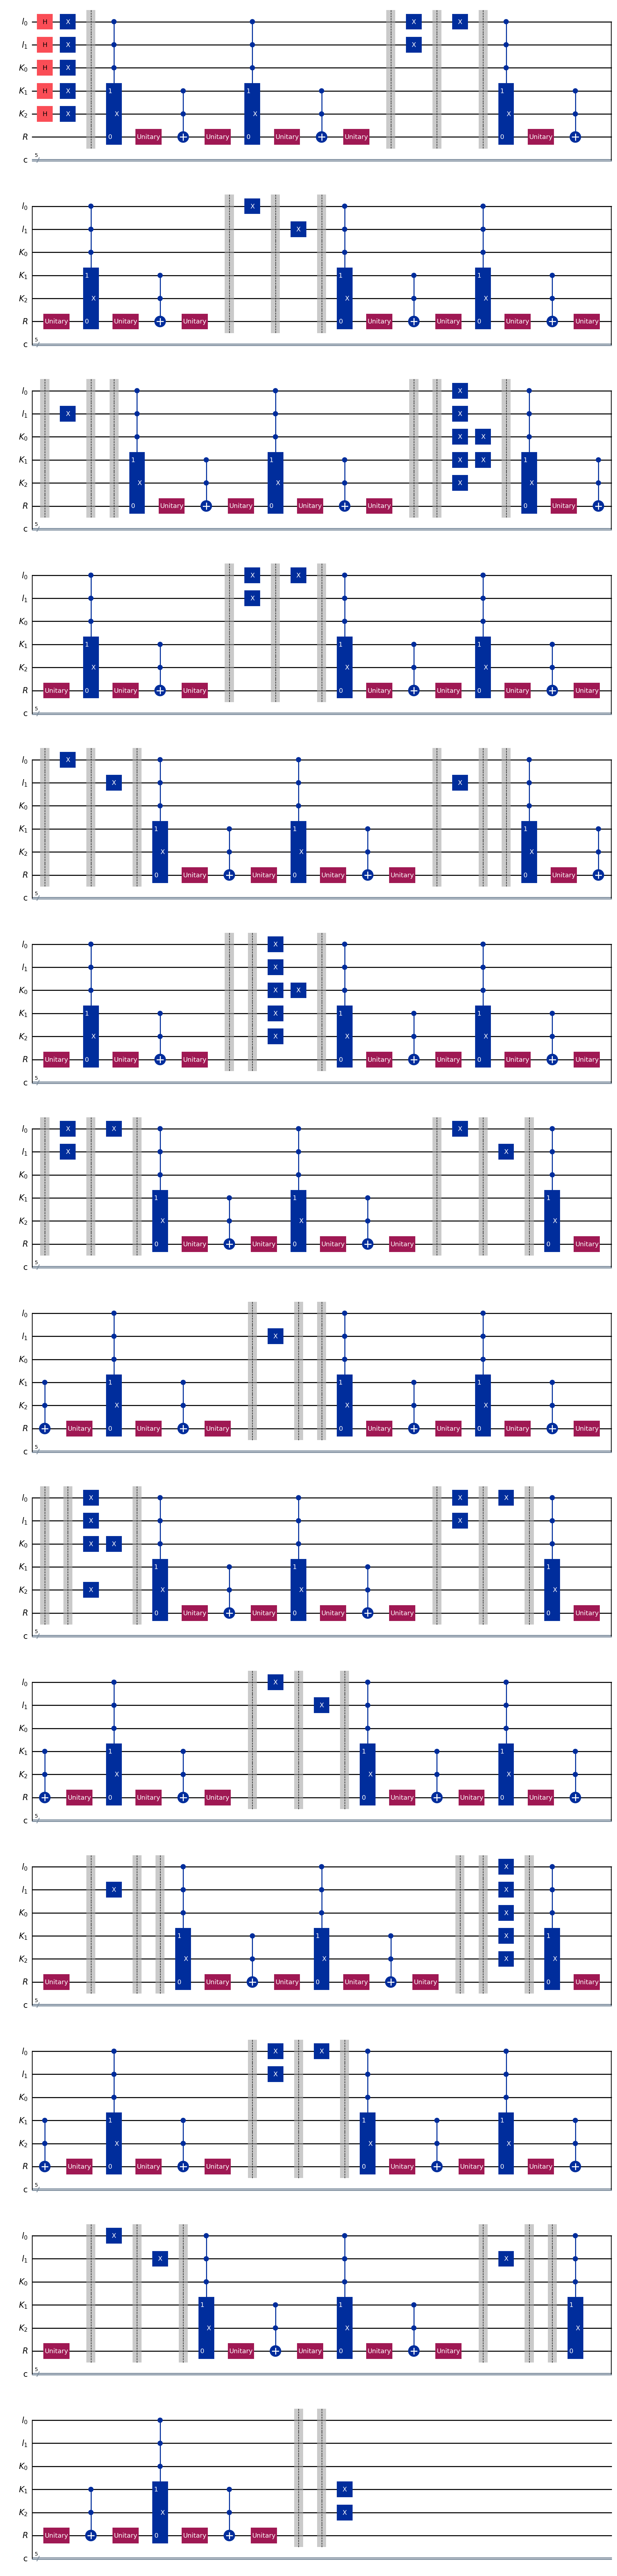



Vector de estado:
 Statevector([ 3.72529031e-09+7.72523785e-16j,
              1.61342027e-01+1.06770110e-15j,
              1.57544110e-01+5.94239853e-16j,
             -3.88105178e-16+7.98334194e-16j,
              1.20449047e-16+4.22560161e-16j,
              1.75009631e-01+1.27874170e-15j,
              8.47279436e-02+1.82823524e-16j,
              1.76273938e-01+1.20177183e-15j,
              1.62112803e-01+1.17280392e-16j,
              1.12143295e-01+5.35765263e-16j,
              1.51512855e-01+9.52002889e-16j,
              1.53364673e-01+3.27839126e-16j,
              1.76776695e-01+1.12568209e-15j,
              1.76776695e-01+1.20158012e-15j,
              1.76776695e-01+9.87225698e-16j,
              1.76776695e-01+1.25800532e-15j,
              1.63072469e-01+1.02146007e-15j,
              2.89345387e-16-4.02636843e-17j,
             -3.59751453e-16+2.65964475e-16j,
              1.76667670e-01+1.14782829e-15j,
              1.76776695e-01+1.18449863e-15j,
             

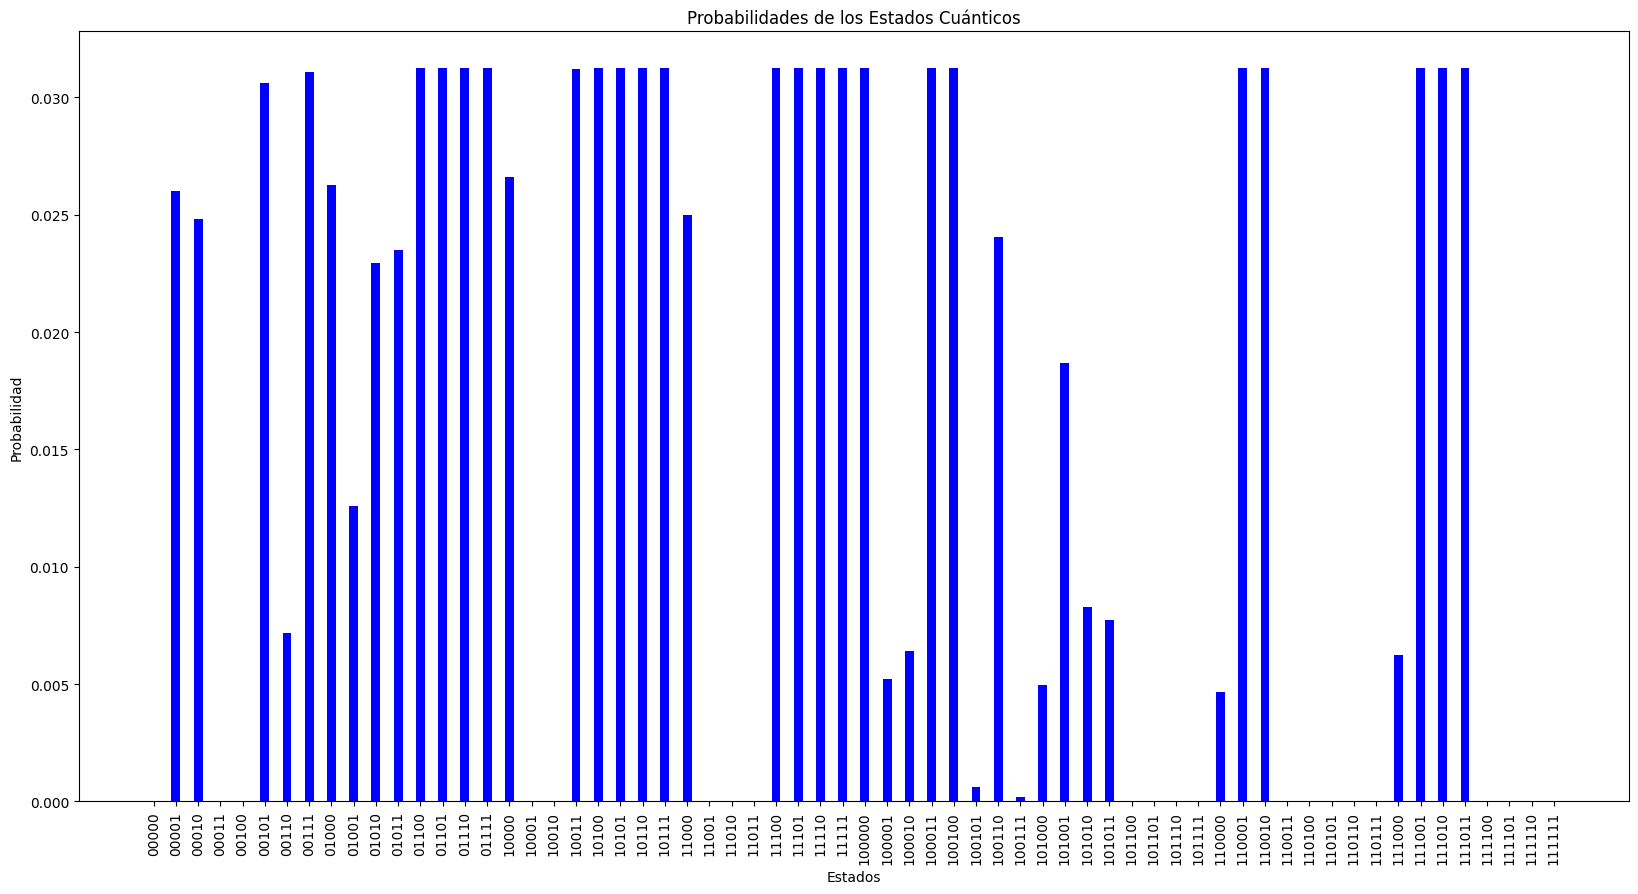

In [6]:

data = normalizing_step(data)
print("\n")
print("Datos normalizados:")
print(data)
print("\n")
#data= inverse_stereo_transform(data)
q_circuit = initializing_circuit(data)


#Ejecución del circuito
#backend = Aer.get_backend('qasm_simulator')
backend = Aer.get_backend('statevector_simulator')
transpiled_circ = transpile(q_circuit, backend)
result = backend.run(transpiled_circ, shots=1024).result()

#Mostramos el circuito
display(q_circuit.draw(output='mpl', reverse_bits=False))


#Obtenemos los resultados

statevector = result.get_statevector()
statevector_array = np.asarray(statevector)

print("\n")
print("Vector de estado:\n", statevector)
# Calcular las probabilidades
probabilities = np.abs(statevector)**2

# Obtener los estados (bits)
states = [bin(i)[2:].zfill(5) for i in range(len(statevector_array))]

#Gráfico de barras
fig, ax = plt.subplots(figsize=(20, 10))
bar_width = 0.4  
positions = np.arange(len(states)) 
ax.bar(positions, probabilities, width=bar_width, color='blue')
ax.set_xticks(positions)
ax.set_xticklabels(states, rotation=90)  
plt.xlabel('Estados')
plt.ylabel('Probabilidad')
plt.title('Probabilidades de los Estados Cuánticos')
plt.show()




<h1><font color="orange" size=5> Desinstalación de módulos </font></h1> 
<h1><font color="white" size=3.6 style=0.3> <p style="line-height: 1.2;">
Sección para desinstalar los módulos a elección del usuario. </p> </font></h1> 


In [ ]:
!python -m pip uninstall qiskit --yes

In [ ]:
!python -m pip uninstall qiskit_aer --yes

In [ ]:
!python -m pip uninstall sklearn.preprocessing --yes

In [ ]:
!python -m pip uninstall numpy --yes

In [ ]:
!python -m pip uninstall matplotlib --yes